In [18]:
%pip install seaborn

from PIL import Image
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

Note: you may need to restart the kernel to use updated packages.


In [19]:
def load_dataset(fname=None, new_size=(10, 10)):
    if fname is None:
        base_dir = os.getcwd()
        fname = os.path.join(base_dir, '../elpv-dataset/labels.csv')

    data = np.genfromtxt(fname, dtype=['|S19', '<f8', '|S4'], names=[
                         'path', 'probability', 'type'])
    image_fnames = np.char.decode(data['path'])
    probs = data['probability']
    types = np.char.decode(data['type'])

    def load_cell_image(fname):
        with Image.open(fname) as image:
            image = image.convert('L')  # Convert to grayscale
            image = image.resize(new_size, Image.Resampling.LANCZOS)  # Resize the image
            return np.asarray(image)

    dir = os.path.dirname(fname)

    images = np.array([load_cell_image(os.path.join(dir, fn))
                       for fn in image_fnames])


    return images, probs, types

images, proba, types = load_dataset(new_size=(10, 10))


In [20]:

X = images.reshape((images.shape[0], -1))

mapping = {0.0: 0,1.0: 1, 0.3333333333333333: 2, 0.6666666666666666: 3}
res = [mapping[x] for x in proba]
arr=np.array(res)
y= arr.astype(int)

In [21]:

type_encoder = LabelEncoder()
types_encoded = type_encoder.fit_transform(types)
# Split the data
X_train, X_test, y_train, y_test, types_train, types_test = train_test_split(X, y, types_encoded, test_size=0.25,
                                                                             random_state=42)
# Filter out 'mono' and 'poly' samples for separate processing
X_train_mono = X_train[types_train == 0]
y_train_mono = y_train[types_train == 0]
X_test_mono = X_test[types_test == 0]
y_test_mono = y_test[types_test == 0]

X_train_poly = X_train[types_train == 1]
y_train_poly = y_train[types_train == 1]
X_test_poly = X_test[types_test == 1]
y_test_poly = y_test[types_test == 1]

In [22]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=150)),  # Adjust the number of components
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'pca__n_components': [50, 100, 150],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, None]
}

pipe_mono = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=100)),
    ('classifier', RandomForestClassifier(random_state=42))
])
pipe_mono.fit(X_train_mono, y_train_mono)

y_pred_mono = pipe_mono.predict(X_test_mono)

pipe_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=100)),
    ('classifier', RandomForestClassifier(random_state=42))
])
pipe_poly.fit(X_train_poly, y_train_poly)

y_pred_poly = pipe_poly.predict(X_test_poly)


In [23]:
grid_search = GridSearchCV(pipe, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

              precision    recall  f1-score   support

           0       0.71      0.91      0.80       372
           1       0.72      0.64      0.68       180
           2       0.88      0.19      0.31        73
           3       0.50      0.03      0.06        31

    accuracy                           0.71       656
   macro avg       0.70      0.44      0.46       656
weighted avg       0.72      0.71      0.67       656

[[338  31   2   1]
 [ 65 115   0   0]
 [ 49  10  14   0]
 [ 26   4   0   1]]


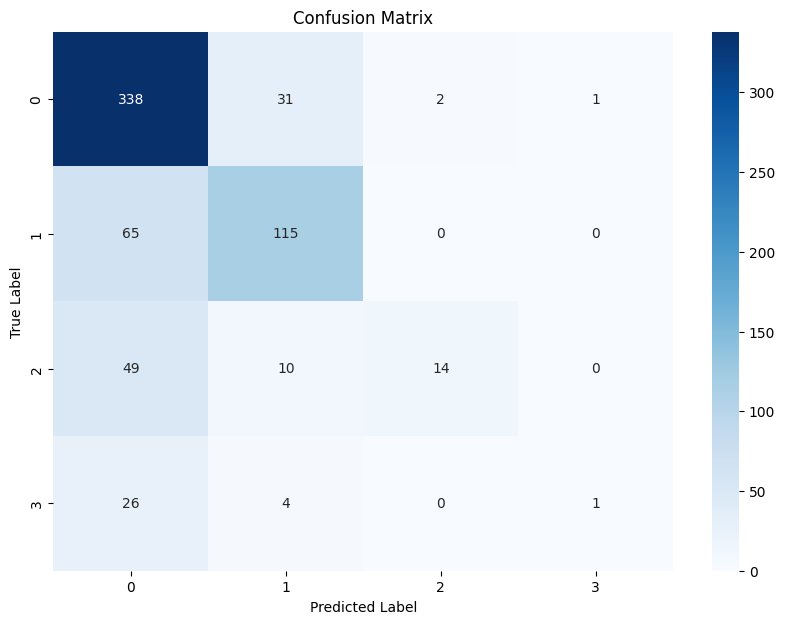

Accuracy on Test Set: 0.71
Classification Report for Mono:
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       147
           1       0.78      0.78      0.78        82
           2       0.62      0.19      0.29        26
           3       0.00      0.00      0.00        18

    accuracy                           0.75       273
   macro avg       0.54      0.48      0.48       273
weighted avg       0.70      0.75      0.71       273

Confusion Matrix for Mono:
[[137   8   2   0]
 [ 17  64   1   0]
 [ 16   5   5   0]
 [ 13   5   0   0]]
Accuracy for Mono: 75.46%

Classification Report for Poly:
              precision    recall  f1-score   support

           0       0.70      0.94      0.80       225
           1       0.75      0.49      0.59        98
           2       0.77      0.21      0.33        47
           3       0.00      0.00      0.00        13

    accuracy                           0.70       383
   macro avg     

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [24]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap='Blues', linecolor='white', annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()

print(f"Accuracy on Test Set: {accuracy:.2f}")

print("Classification Report for Mono:")
print(classification_report(y_test_mono, y_pred_mono))
print("Confusion Matrix for Mono:")
print(confusion_matrix(y_test_mono, y_pred_mono))
print("Accuracy for Mono: {:.2f}%".format(100 * accuracy_score(y_test_mono, y_pred_mono)))

print("\nClassification Report for Poly:")
print(classification_report(y_test_poly, y_pred_poly))
print("Confusion Matrix for Poly:")
print(confusion_matrix(y_test_poly, y_pred_poly))
print("Accuracy for Poly: {:.2f}%".format(100 * accuracy_score(y_test_poly, y_pred_poly)))